In [14]:
import itertools

import numpy.random as random
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
from keras.callbacks import EarlyStopping
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, PredefinedSplit, ParameterGrid
from keras.models import Sequential
from keras.layers import Dense
from keras import activations, optimizers, regularizers, losses, initializers
from functools import partial
from sklearn.utils import shuffle

pd.set_option('display.max_rows', None)

What is the lower bound for the number of training examples, N?
- N >= n
- lower bound is amount of rbf kernels n

What happens with the error if N = n? Why?
- if we have as many rbf kernels n as samples N then we are overfitting, each rbf kernel can select one sample as its prototype vector and the error is 0

Under what conditions, if any, does (4) have a solution in this case?
- ??

During training we use an error measure defined over the training examples. Is it good to use this measure when evaluating the performance of the network? Explain!
- No, because we don't get information about the generalization error.
- We do not notice if we overfit or not, if we do not use validation / test sets.


# 3.1 Supervised learning of RBF NN

In [2]:
def sin_function(x):
    return np.sin(2 * x).reshape(-1, 1)


def square_function(x):
    a = (np.sin(2 * x) >= 0).astype(float).reshape(-1, 1)
    a[a == 0] = -1
    return a


def generate_X(start=0, stop=2 * np.pi, step_size=0.1):
    return np.arange(start, stop, step_size).reshape(-1, 1)


def get_train_data(noise=False):
    X_train = generate_X()
    y_train_sin = sin_function(X_train)
    y_train_square = square_function(X_train)

    if noise:
        X_train += np.random.normal(0, 0.1, (len(X_train), 1))
        y_train_sin += np.random.normal(0, 0.1, (len(X_train), 1))
        y_train_square += np.random.normal(0, 0.1, (len(X_train), 1))

    return X_train, y_train_sin, y_train_square


def get_test_data(noise=False):
    X_test = generate_X(start=0.05)
    y_test_sin = sin_function(X_test)
    y_test_square = square_function(X_test)

    if noise:
        X_test += np.random.normal(0, 0.1, (len(X_test), 1))
        y_test_sin += np.random.normal(0, 0.1, (len(X_test), 1))
        y_test_square += np.random.normal(0, 0.1, (len(X_test), 1))

    return X_test, y_test_sin, y_test_square


def get_rbf_kernels(num, std=0.1):
    number_of_kernel = num

    rbf_center_sin = np.linspace(start=0, stop=2 * np.pi, num=number_of_kernel)
    y_rbf_sin = sin_function(rbf_center_sin)

    rbf_center_square = np.linspace(start=0, stop=2 * np.pi, num=number_of_kernel)
    y_rbf_square = square_function(rbf_center_square)

    kernel_stds = std * np.ones((len(rbf_center_square),)).reshape(-1, 1)

    return kernel_stds, rbf_center_sin, rbf_center_square, y_rbf_sin, y_rbf_square


X_train, y_train_sin, y_train_square = get_train_data()
X_test, y_test_sin, y_test_square = get_test_data()
kernel_stds, rbf_center_sin, rbf_center_square, y_rbf_sin, y_rbf_square = get_rbf_kernels(10)

residual_error_thresholds = [0.1, 0.01, 0.001]

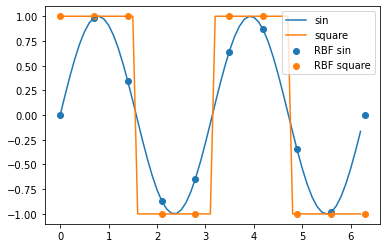

In [3]:
plt.plot(X_train, y_train_sin, label="sin")
plt.plot(X_train, y_train_square, label="square")
plt.scatter(rbf_center_sin, y_rbf_sin, label="RBF sin")
plt.scatter(rbf_center_square, y_rbf_square, label="RBF square")
plt.legend()
plt.show()


In [4]:

def plot_rbf_with_data(rbf, X, y):
    y_pred = rbf.predict(X)

    plt.plot(X, y, label="Sin")
    plt.scatter(rbf.kernel_centers, [0] * len(rbf.kernel_centers), label="RBF")
    plt.plot(X, y_pred, label="Pred")
    plt.legend()
    plt.show()


In [19]:
class RBFNet:
    def __init__(self, kernel_centers=None, kernel_stds=None, k=None,
                 delta_lr=0.01, cl_lr=0.3, delta_epochs=200, cl_epochs=100):
        self.delta_lr = delta_lr
        self.cl_lr = cl_lr
        self.delta_epochs = delta_epochs
        self.cl_epochs = cl_epochs
        self.kernel_centers = kernel_centers
        self.kernel_stds = kernel_stds
        if kernel_centers is None:
            self.k = k
        else:
            self.k = len(kernel_centers)
        self.w = self.init_weights()
        self.patience = 10
        self.delta_threshold = 0.0001

    def rbf_function(self, x, center, std):
        return np.exp(-((x - center) ** 2) / (2 * std ** 2))

    def calc_expanded_X(self, X):
        if np.ndim(np.squeeze(X)) == 0:
            phi = np.array(
                [self.rbf_function(np.squeeze(X), c, s) for c, s, in
                 zip(self.kernel_centers, self.kernel_stds)]).reshape(-1, 1)
            assert phi.shape == (self.k, 1)
            return phi

        rows = []
        for i in range(X.shape[0]):
            print("X_i", X[i].shape, X[i])
            row = [self.rbf_function(X[i], c, s) for c, s, in zip(self.kernel_centers, self.kernel_stds)]
            rows.append(row)
        phi = np.hstack(rows).T  # vstack does not work :((((((((
        print("phi", phi.shape)
        assert phi.shape == (X.shape[0], self.k)
        return phi

    def forward_pass(self, X):
        phi = self.calc_expanded_X(X)
        if phi.shape == (self.k, 1):  #might produce error if samples = k
            return phi.T @ self.w
        return phi @ self.w

    def sum_of_squared_diff(self, y_pred, y_true):
        return np.sum((y_pred - y_true) ** 2)

    def mean_absolute_error(self, y_pred, y_true):
        return 1 / len(y_pred) * np.sum(np.abs(y_pred - y_true))

    def perceptron_batch_learning(self, X, y):
        phi = self.calc_expanded_X(X)
        inv_cov = np.linalg.inv(phi.T @ phi)
        self.w = inv_cov @ phi.T @ y
        assert self.w.shape == (self.k, 1)

    def delta_online_learning(self, X, y):  # sequential
        X, y = shuffle(X, y)

        for i in range(len(X)):
            _x, _y = np.squeeze(X[i, :]), np.squeeze(y[i, :])
            error = np.squeeze(_y - self.forward_pass(_x))
            if np.ndim(np.squeeze(error)) == 0:
                w_delta = self.delta_lr * error * self.calc_expanded_X(_x)
            else:
                w_delta = self.delta_lr * error @ self.calc_expanded_X(_x)
            assert w_delta.shape == (self.k, 1)
            self.w += w_delta

        assert self.w.shape == (self.k, 1)

    def init_weights(self):
        self.w = np.random.randn(self.k, 1)

    def fit(self, X, y, rule="perceptron", cl=None):
        # init
        if self.kernel_centers is None:
            if cl is None:
                self.init_random_prototype_vectors(X)
            else:
                self.init_rbf_kernels_with_cl(X, cl)
        self.init_weights()

        # learn
        patience = self.patience
        last_error = np.inf
        if rule == "delta":
            for epoch in range(self.delta_epochs):
                self.delta_online_learning(X, y)

                # abort if converged
                new_error = self.evaluate_residual_error(X, y)
                diff = last_error - new_error
                if diff <= 0 or diff < self.delta_threshold:
                    # worse or small change -> stop if we did not improve over patience epochs
                    patience -= 1
                else:
                    patience = self.patience

                if patience <= 0:
                    print(f"Converged at epoch {epoch}")
                    break
                last_error = new_error
        else:
            self.perceptron_batch_learning(X, y)

        print("After Train - Error: ", self.evaluate_residual_error(X, y))

    def predict(self, X, sign=False):
        y_pred = self.forward_pass(X)
        if sign:
            y_pred = np.sign(y_pred)
        return y_pred

    def fit_and_predict(self, X, y, rule="perceptron", cl=None, sign=False):
        self.fit(X, y, rule, cl)
        return self.predict(X, sign)

    def evaluate_residual_error(self, X, y, sign=False):
        y_pred = self.predict(X, sign)
        return self.mean_absolute_error(y_pred, y)

    def init_rbf_kernels_with_cl(self, X, mode="hard"):
        self.init_random_prototype_vectors(X)

        for epoch in range(self.cl_epochs):
            if mode == "hard":
                for _ in X:
                    rnd_sample = X[np.random.randint(len(X))]
                    winner_index = self.get_index_nearest_rbf_kernel(rnd_sample)
                    self.update_winner(winner_index, rnd_sample)

            else:  # soft
                for _ in X:
                    rnd_sample = X[np.random.randint(len(X))]
                    winner_index = self.get_index_nearest_rbf_kernel(rnd_sample)
                    self.update_neighborhood_of(winner_index, rnd_sample, epoch)

        self.init_kernel_stds(X)

    def update_winner(self, winner_index, rnd_sample, factor=1):
        # update prototype vector
        delta = self.cl_lr * factor * (rnd_sample - self.kernel_centers[winner_index])
        self.kernel_centers[winner_index] += delta

    def update_neighborhood_of(self, winner_index, rnd_sample, epoch):
        winner = self.kernel_centers[winner_index]  #, :
        dist = np.sum((self.kernel_centers - winner) ** 2, axis=1)
        assert dist.shape == (self.k,)

        factors = np.array([self.neighborhood_function(d, epoch) for d in dist])
        print(factors)
        assert factors.shape == (self.k,)

        for kernel_i in range(self.k):
            self.update_winner(kernel_i, rnd_sample, factors[kernel_i])

    def neighborhood_function(self, distance, epoch):
        return np.exp(- (distance ** 2) / (2 * self.calc_sigma(epoch) ** 2))

    def calc_sigma(self, epoch, sigma_0=0.2):
        return sigma_0 * np.exp(- epoch ** 2 / self.cl_epochs)  # epoch ~linear or epoch ** 2 ~straight down

    def get_index_nearest_rbf_kernel(self, sample):
        dist = np.sum((self.kernel_centers - sample) ** 2, axis=1)
        assert dist.shape == (self.k,)
        min_index = np.argmin(dist)
        return min_index

    def init_random_prototype_vectors(self, X):
        rnd_samples = X[np.random.randint(low=len(X), size=self.k)]
        self.kernel_centers = rnd_samples
        self.init_kernel_stds(X)

    def nearest_kernel(self, X):
        distances = np.squeeze(np.abs(X[:, np.newaxis] - self.kernel_centers[np.newaxis, :]))
        closest_kernel = np.argmin(distances, axis=1)
        return closest_kernel

    def init_kernel_stds(self, X):
        fix_stds = False
        stds = []
        closest_kernels = self.nearest_kernel(X)

        for i in range(self.k):
            points_for_kernel = X[closest_kernels == i]
            if len(points_for_kernel) >= 2:
                std = np.std(X[closest_kernels == i])
                stds.append(std)
            else:
                fix_stds = True
                stds.append(0)

        stds = np.array(stds).reshape(-1, )

        if fix_stds:
            # set clusters with std = 0 to mean std of other kernels
            mean = np.mean(stds[stds != 0])
            stds[stds == 0] = mean

        self.kernel_stds = stds * 3


Kernels 1
Loss: 60.7825
Residual Error (MAE): 0.8571
Residual Error (MAE): 0.9785

Kernels 2
Loss: 59.2265
Residual Error (MAE): 0.9841
Residual Error (MAE): 0.9593

Kernels 3
Loss: 59.2091
Residual Error (MAE): 0.5079
Residual Error (MAE): 0.9607

Kernels 4
Loss: 52.1373
Residual Error (MAE): 0.3492
Residual Error (MAE): 0.8778

Kernels 5
Loss: 58.7722
Residual Error (MAE): 0.7619
Residual Error (MAE): 0.9648

Kernels 6
Loss: 45.0904
Residual Error (MAE): 0.1905
Residual Error (MAE): 0.7893

Kernels 7
Loss: 45.0295
Residual Error (MAE): 0.1587
Residual Error (MAE): 0.7925

Kernels 8
Loss: 38.0779
Residual Error (MAE): 0.1587
Residual Error (MAE): 0.7181

Kernels 9
Loss: 44.5928
Residual Error (MAE): 0.3810
Residual Error (MAE): 0.7972

Kernels 10
Loss: 32.5989
Residual Error (MAE): 0.0952
Residual Error (MAE): 0.6319

Kernels 11
Loss: 30.9003
Residual Error (MAE): 0.0952
Residual Error (MAE): 0.6231

Kernels 12
Loss: 24.8342
Residual Error (MAE): 0.1270
Residual Error (MAE): 0.5567

K

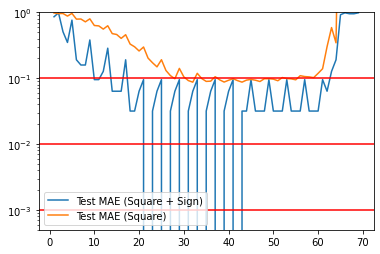

In [134]:

X_train, y_train_sin, y_train_square = get_train_data()
X_test, y_test_sin, y_test_square = get_test_data()

num_of_kernels = np.arange(1, 70, 1)
square_sign_maes = []
square_maes = []

for k in num_of_kernels:
    print(f"Kernels {k}")
    kernel_stds, rbf_center_sin, rbf_center_square, y_rbf_sin, y_rbf_square = get_rbf_kernels(num=k)

    rbf_square = RBFNet(kernel_centers=rbf_center_square, kernel_stds=kernel_stds)
    y_pred_square = rbf_square.fit_and_predict(X_train, y_train_square, sign=True)

    square_sign_test_loss = rbf_square.evaluate_residual_error(X_test, y_test_square, sign=True)
    square_test_loss = rbf_square.evaluate_residual_error(X_test, y_test_square, sign=False)

    square_sign_maes.append(square_sign_test_loss)
    square_maes.append(square_test_loss)
    print("")

best_k_square = np.argmin(square_maes)
print("Best", best_k_square, square_maes[best_k_square])

plt.plot(num_of_kernels, square_sign_maes, label="Test MAE (Square + Sign)")
plt.plot(num_of_kernels, square_maes, label="Test MAE (Square)")
plt.axhline(y=residual_error_thresholds[0], c="r")
plt.axhline(y=residual_error_thresholds[1], c="r")
plt.axhline(y=residual_error_thresholds[2], c="r")
plt.yscale('log')
plt.ylim(0.0005, 1)
#plt.yticks([0.1, 0.01, 0.001])
plt.legend()
plt.show()


Loss: 2.0767
Residual Error (MAE): 0.0317


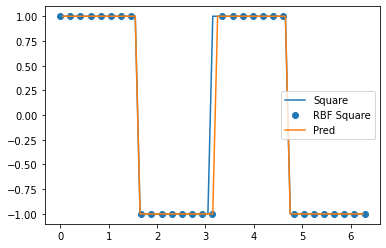

In [135]:
kernel_stds, rbf_center_sin, rbf_center_square, y_rbf_sin, y_rbf_square = get_rbf_kernels(num=best_k_square)

rbf_square = RBFNet(kernel_centers=rbf_center_square, kernel_stds=kernel_stds)
y_pred_square = rbf_square.fit_and_predict(X_train, y_train_square, sign=True)

square_test_loss = rbf_square.evaluate_residual_error(X_test, y_test_square, sign=True)

y_pred_test = rbf_square.predict(X_test, sign=True)

plt.plot(X_test, y_test_square, label="Square")
plt.scatter(rbf_center_square, y_rbf_square, label="RBF Square")
plt.plot(X_test, y_pred_test, label="Pred")
plt.legend()
plt.show()


Kernels 1
Loss: 31.3932
Residual Error (MAE): 0.6329

Kernels 2
Loss: 31.3228
Residual Error (MAE): 0.6335

Kernels 3
Loss: 31.3228
Residual Error (MAE): 0.6335

Kernels 4
Loss: 26.2144
Residual Error (MAE): 0.5631

Kernels 5
Loss: 31.3228
Residual Error (MAE): 0.6335

Kernels 6
Loss: 22.8080
Residual Error (MAE): 0.5079

Kernels 7
Loss: 21.1051
Residual Error (MAE): 0.4900

Kernels 8
Loss: 19.4031
Residual Error (MAE): 0.4594

Kernels 9
Loss: 17.6994
Residual Error (MAE): 0.4660

Kernels 10
Loss: 15.9976
Residual Error (MAE): 0.4115

Kernels 11
Loss: 14.2937
Residual Error (MAE): 0.3788

Kernels 12
Loss: 12.5956
Residual Error (MAE): 0.3598

Kernels 13
Loss: 10.9109
Residual Error (MAE): 0.3441

Kernels 14
Loss: 9.2632
Residual Error (MAE): 0.3074

Kernels 15
Loss: 7.6850
Residual Error (MAE): 0.2789

Kernels 16
Loss: 6.2173
Residual Error (MAE): 0.2599

Kernels 17
Loss: 4.8994
Residual Error (MAE): 0.2320

Kernels 18
Loss: 3.7576
Residual Error (MAE): 0.2012

Kernels 19
Loss: 2.8062


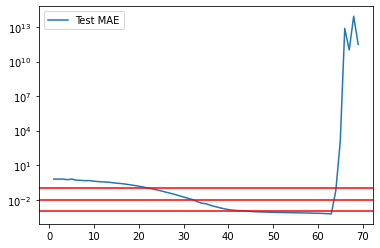

In [136]:

X_train, y_train_sin, y_train_square = get_train_data()
X_test, y_test_sin, y_test_square = get_test_data()

num_of_kernels = np.arange(1, 70, 1)
sin_maes = []

for k in num_of_kernels:
    print(f"Kernels {k}")
    kernel_stds, rbf_center_sin, rbf_center_square, y_rbf_sin, y_rbf_square = get_rbf_kernels(num=k)

    rbf_sin = RBFNet(kernel_centers=rbf_center_sin, kernel_stds=kernel_stds)
    y_pred_sin = rbf_sin.fit_and_predict(X_train, y_train_sin)

    sin_test_loss = rbf_sin.evaluate_residual_error(X_test, y_test_sin)

    sin_maes.append(sin_test_loss)
    print("")

best_k_sin = np.argmin(sin_maes)
print("Best", best_k_sin, sin_maes[best_k_sin])

plt.plot(num_of_kernels, sin_maes, label="Test MAE")
plt.axhline(y=residual_error_thresholds[0], c="r")
plt.axhline(y=residual_error_thresholds[1], c="r")
plt.axhline(y=residual_error_thresholds[2], c="r")
plt.yscale('log')
#plt.yticks([0.1, 0.01, 0.001])
plt.legend()
plt.show()


Loss: 0.0000
Residual Error (MAE): 0.0006


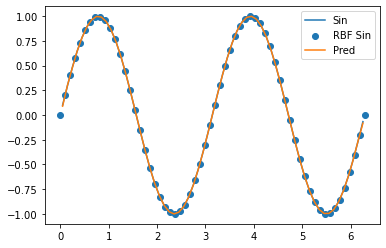

In [137]:
kernel_stds, rbf_center_sin, rbf_center_square, y_rbf_sin, y_rbf_square = get_rbf_kernels(num=best_k_sin)

rbf_sin = RBFNet(kernel_centers=rbf_center_sin, kernel_stds=kernel_stds)
y_pred_sin = rbf_sin.fit_and_predict(X_train, y_train_sin)

sin_test_loss = rbf_sin.evaluate_residual_error(X_test, y_test_sin)
y_pred_test = rbf_sin.predict(X_test)

plt.plot(X_test, y_test_sin, label="Sin")
plt.scatter(rbf_center_sin, y_rbf_sin, label="RBF Sin")
plt.plot(X_test, y_pred_test, label="Pred")
plt.legend()
plt.show()


How can you simply transform the output of your RBF network to reduce the residual error to 0 for the square(2x) problem? Still, how many units do you need? In what type of applications could this transform be particularly useful?
- sign activation function to {-1, 1}
- classification
- 30 units for test set residual error = 0


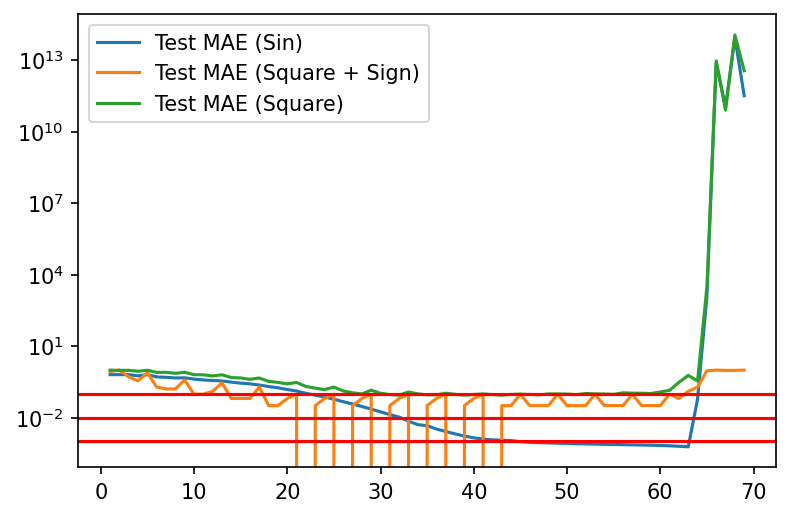

In [138]:
plt.figure(figsize=(6, 4), dpi=150)

plt.plot(num_of_kernels, sin_maes, label="Test MAE (Sin)")
plt.plot(num_of_kernels, square_sign_maes, label="Test MAE (Square + Sign)")
plt.plot(num_of_kernels, square_maes, label="Test MAE (Square)")
plt.axhline(y=residual_error_thresholds[0], c="r")
plt.axhline(y=residual_error_thresholds[1], c="r")
plt.axhline(y=residual_error_thresholds[2], c="r")
plt.yscale('log')
#plt.yticks([0.1, 0.01, 0.001])
plt.legend()
plt.show()


# 3.2 Regression with noise AND ONLINE

Kernels 1
Loss: 63.0658
Residual Error (MAE): 0.8877
Residual Error (MAE): 0.9632

Kernels 2
Loss: 61.6045
Residual Error (MAE): 0.9751
Residual Error (MAE): 0.9294

Kernels 3
Loss: 61.3756
Residual Error (MAE): 0.6107
Residual Error (MAE): 0.9208

Kernels 4
Loss: 53.8833
Residual Error (MAE): 0.4502
Residual Error (MAE): 0.8598

Kernels 5
Loss: 61.1840
Residual Error (MAE): 0.8669
Residual Error (MAE): 0.9417

Kernels 6
Loss: 46.1372
Residual Error (MAE): 0.3354
Residual Error (MAE): 0.7738

Kernels 7
Loss: 45.8465
Residual Error (MAE): 0.3428
Residual Error (MAE): 0.7721

Kernels 8
Loss: 39.5756
Residual Error (MAE): 0.2694
Residual Error (MAE): 0.6977

Kernels 9
Loss: 42.5447
Residual Error (MAE): 0.4238
Residual Error (MAE): 0.7337

Kernels 10
Loss: 36.8157
Residual Error (MAE): 0.2483
Residual Error (MAE): 0.6439

Kernels 11
Loss: 31.3200
Residual Error (MAE): 0.2529
Residual Error (MAE): 0.6100

Kernels 12
Loss: 27.9793
Residual Error (MAE): 0.2377
Residual Error (MAE): 0.5731

K

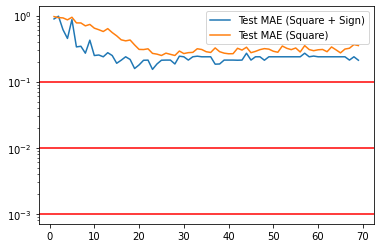

In [139]:

X_train, y_train_sin, y_train_square = get_train_data(noise=1)
X_test, y_test_sin, y_test_square = get_test_data(noise=1)

num_of_kernels = np.arange(1, 70, 1)
square_sign_maes = []
square_maes = []

for k in num_of_kernels:
    print(f"Kernels {k}")
    kernel_stds, rbf_center_sin, rbf_center_square, y_rbf_sin, y_rbf_square = get_rbf_kernels(num=k)

    rbf_square = RBFNet(kernel_centers=rbf_center_square, kernel_stds=kernel_stds)
    y_pred_square = rbf_square.fit_and_predict(X_train, y_train_square, rule="delta")

    square_sign_test_loss = rbf_square.evaluate_residual_error(X_test, y_test_square, sign=True)
    square_test_loss = rbf_square.evaluate_residual_error(X_test, y_test_square, sign=False)

    square_sign_maes.append(square_sign_test_loss)
    square_maes.append(square_test_loss)
    print("")

best_k_square_noise = np.argmin(square_maes)
print("Best", best_k_square_noise, square_maes[best_k_square_noise])

plt.plot(num_of_kernels, square_sign_maes, label="Test MAE (Square + Sign)")
plt.plot(num_of_kernels, square_maes, label="Test MAE (Square)")
plt.axhline(y=residual_error_thresholds[0], c="r")
plt.axhline(y=residual_error_thresholds[1], c="r")
plt.axhline(y=residual_error_thresholds[2], c="r")
plt.yscale('log')
#plt.ylim(0.0005, 1)
#plt.yticks([0.1, 0.01, 0.001])
plt.legend()
plt.show()


Loss: 1.9942
Residual Error (MAE): 0.1897


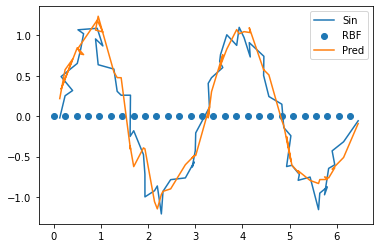

In [140]:

X_train, y_train_sin, y_train_square = get_train_data(noise=True)
X_test, y_test_sin, y_test_square = get_test_data(noise=True)

kernel_stds, rbf_center_sin, rbf_center_square, y_rbf_sin, y_rbf_square = get_rbf_kernels(num=best_k_square_noise)

rbf_noise = RBFNet(kernel_centers=rbf_center_sin, kernel_stds=kernel_stds)
y_pred_train_sin = rbf_noise.fit_and_predict(X_train, y_train_sin, rule="delta")

sin_test_loss = rbf_noise.evaluate_residual_error(X_test, y_test_sin)
y_pred_test_sin = rbf_noise.predict(X_test)

plot_rbf_with_data(rbf_noise, X_test, y_test_sin)

Kernels 1
Loss: 32.9228
Residual Error (MAE): 0.6403

Kernels 2
Loss: 32.8410
Residual Error (MAE): 0.6378

Kernels 3
Loss: 32.6331
Residual Error (MAE): 0.6366

Kernels 4
Loss: 27.8899
Residual Error (MAE): 0.5636

Kernels 5
Loss: 32.9596
Residual Error (MAE): 0.6390

Kernels 6
Loss: 23.6110
Residual Error (MAE): 0.5069

Kernels 7
Loss: 22.1996
Residual Error (MAE): 0.4905

Kernels 8
Loss: 19.2880
Residual Error (MAE): 0.4528

Kernels 9
Loss: 20.8286
Residual Error (MAE): 0.4889

Kernels 10
Loss: 16.6388
Residual Error (MAE): 0.4116

Kernels 11
Loss: 15.2898
Residual Error (MAE): 0.3876

Kernels 12
Loss: 15.4532
Residual Error (MAE): 0.3852

Kernels 13
Loss: 10.7628
Residual Error (MAE): 0.3136

Kernels 14
Loss: 10.2084
Residual Error (MAE): 0.3078

Kernels 15
Loss: 7.6022
Residual Error (MAE): 0.2899

Kernels 16
Loss: 5.8348
Residual Error (MAE): 0.2453

Kernels 17
Loss: 6.5277
Residual Error (MAE): 0.2576

Kernels 18
Loss: 7.1094
Residual Error (MAE): 0.2864

Kernels 19
Loss: 4.5785

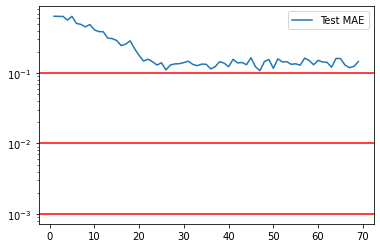

In [141]:

X_train, y_train_sin, y_train_square = get_train_data(noise=1)
X_test, y_test_sin, y_test_square = get_test_data(noise=1)

num_of_kernels = np.arange(1, 70, 1)
sin_maes = []

for k in num_of_kernels:
    print(f"Kernels {k}")
    kernel_stds, rbf_center_sin, rbf_center_square, y_rbf_sin, y_rbf_square = get_rbf_kernels(num=k)

    rbf_sin = RBFNet(kernel_centers=rbf_center_sin, kernel_stds=kernel_stds)
    y_pred_sin = rbf_sin.fit_and_predict(X_train, y_train_sin, rule="delta")

    sin_test_loss = rbf_sin.evaluate_residual_error(X_train, y_train_sin)

    sin_maes.append(sin_test_loss)
    print("")

best_k_sin_noise = np.argmin(square_maes)
print("Best", best_k_sin_noise, square_maes[best_k_sin_noise])

plt.plot(num_of_kernels, sin_maes, label="Test MAE")
plt.axhline(y=residual_error_thresholds[0], c="r")
plt.axhline(y=residual_error_thresholds[1], c="r")
plt.axhline(y=residual_error_thresholds[2], c="r")
plt.yscale('log')
#plt.yticks([0.1, 0.01, 0.001])
plt.legend()
plt.show()


Loss: 1.9430
Residual Error (MAE): 0.2188


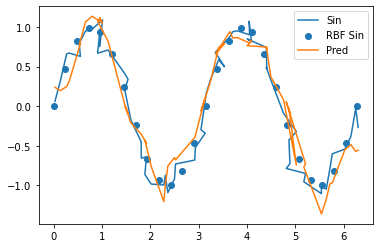

In [142]:
kernel_stds, rbf_center_sin, rbf_center_square, y_rbf_sin, y_rbf_square = get_rbf_kernels(num=best_k_sin_noise)

rbf_sin = RBFNet(kernel_centers=rbf_center_sin, kernel_stds=kernel_stds)
y_pred_sin = rbf_sin.fit_and_predict(X_train, y_train_sin, rule="delta")

sin_test_loss = rbf_sin.evaluate_residual_error(X_test, y_test_sin)
y_pred_test = rbf_sin.predict(X_test)

plt.plot(X_test, y_test_sin, label="Sin")
plt.scatter(rbf_center_sin, y_rbf_sin, label="RBF Sin")
plt.plot(X_test, y_pred_test, label="Pred")
plt.legend()
plt.show()


# 3.3 Competitive learning to initialize RBF

In [143]:
noise = False

Kernels 1
Kernels 2
Loss: 30.5628
Residual Error (MAE): 0.6179

Kernels 3
Loss: 18.8482
Residual Error (MAE): 0.4426

Kernels 4
Loss: 13.2774
Residual Error (MAE): 0.4091

Kernels 5
Loss: 11.3458
Residual Error (MAE): 0.3189

Kernels 6
Loss: 12.5020
Residual Error (MAE): 0.3890

Kernels 7
Loss: 9.5001
Residual Error (MAE): 0.2999

Kernels 8
Loss: 7.5850
Residual Error (MAE): 0.2814

Kernels 9
Loss: 0.9020
Residual Error (MAE): 0.0987

Kernels 10
Loss: 0.9623
Residual Error (MAE): 0.0976

Kernels 11
Loss: 0.7718
Residual Error (MAE): 0.0798

Kernels 12
Loss: 0.1201
Residual Error (MAE): 0.0333

Kernels 13
Loss: 0.6557
Residual Error (MAE): 0.0805

Kernels 14
Loss: 0.1988
Residual Error (MAE): 0.0323

Kernels 15
Loss: 0.0895
Residual Error (MAE): 0.0311

Kernels 16
Loss: 0.0142
Residual Error (MAE): 0.0093

Kernels 17
Loss: 0.0442
Residual Error (MAE): 0.0218

Kernels 18
Kernels 19
Loss: 0.0188
Residual Error (MAE): 0.0119

Kernels 20
Loss: 2671888181756601213852319744.0000
Residual Erro

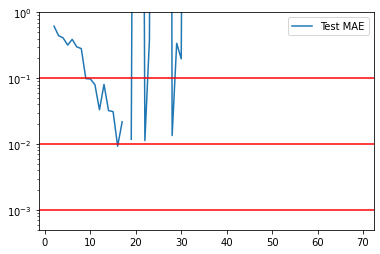

In [144]:

X_train, y_train_sin, y_train_square = get_train_data(noise)
X_test, y_test_sin, y_test_square = get_test_data(noise)

num_of_kernels = np.arange(1, 70, 1)
maes = []

for k in num_of_kernels:
    print(f"Kernels {k}")
    try:
        rbf_vq = RBFNet(k=k, delta_epochs=200, cl_epochs=200)

        y_pred_sin = rbf_vq.fit_and_predict(X_train, y_train_sin, rule="delta", cl="hard")

        mae = rbf_vq.evaluate_residual_error(X_test, y_test_sin)

        maes.append(mae)
        print("")
    except:
        maes.append(np.inf)

best_k_sin_cl = np.argmin(maes)
print("Best", best_k_sin_cl, maes[best_k_sin_cl])

plt.plot(num_of_kernels, maes, label="Test MAE")
plt.axhline(y=residual_error_thresholds[0], c="r")
plt.axhline(y=residual_error_thresholds[1], c="r")
plt.axhline(y=residual_error_thresholds[2], c="r")
plt.yscale('log')
plt.ylim(0.0005, 1)
#plt.yticks([0.1, 0.01, 0.001])
plt.legend()
plt.show()


Converged at epoch 92


,0
0.047785,5.045262
0.315113,4.383375
0.329985,6.059903
0.434226,1.822332
0.296001,4.740343
0.314449,2.825051
0.296001,4.931506
0.479563,0.527742
0.259577,2.386245
0.110136,5.220955


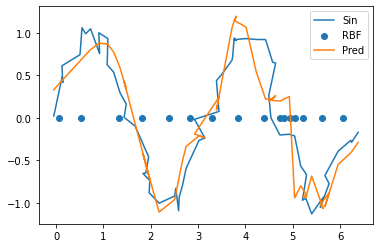

In [154]:

X_train, y_train_sin, y_train_square = get_train_data(noise)
X_test, y_test_sin, y_test_square = get_test_data(noise)

rbf_vq = RBFNet(k=best_k_sin_cl, delta_epochs=200, cl_epochs=200)
y_pred_train_sin = rbf_vq.fit_and_predict(X_train, y_train_sin, rule="delta", cl="hard")

sin_test_loss = rbf_vq.evaluate_residual_error(X_test, y_test_sin)
y_pred_test_sin = rbf_vq.predict(X_test)

display(pd.DataFrame(rbf_vq.kernel_centers, rbf_vq.kernel_stds))

plot_rbf_with_data(rbf_vq, X_test, y_test_sin)


Kernels 1
Kernels 2
Loss: 55.4999
Residual Error (MAE): 0.8748

Kernels 3
Loss: 54.5406
Residual Error (MAE): 0.8669

Kernels 4
Loss: 38.4003
Residual Error (MAE): 0.6465

Kernels 5
Loss: 16.3576
Residual Error (MAE): 0.4044

Kernels 6
Loss: 11.0075
Residual Error (MAE): 0.3215

Kernels 7
Loss: 11.1761
Residual Error (MAE): 0.3177

Kernels 8
Loss: 9.5461
Residual Error (MAE): 0.2950

Kernels 9
Loss: 9.3377
Residual Error (MAE): 0.2904

Kernels 10
Loss: 8.5355
Residual Error (MAE): 0.2700

Kernels 11
Loss: 7.7180
Residual Error (MAE): 0.2466

Kernels 12
Loss: 7.4550
Residual Error (MAE): 0.2399

Kernels 13
Loss: 4.9177
Residual Error (MAE): 0.1974

Kernels 14
Loss: 7.5823
Residual Error (MAE): 0.2436

Kernels 15
Kernels 16
Loss: 4.1967
Residual Error (MAE): 0.1746

Kernels 17
Kernels 18
Loss: 3.9892
Residual Error (MAE): 0.1645

Kernels 19
Loss: 207678073757390426397999104.0000
Residual Error (MAE): 946890717221.4799

Kernels 20
Kernels 21
Loss: 3.4463
Residual Error (MAE): 0.1546

Kern

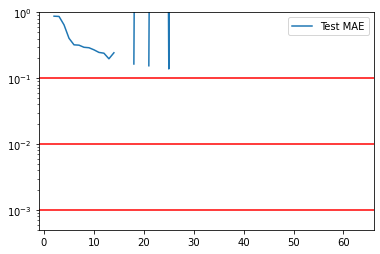

In [146]:

X_train, y_train_sin, y_train_square = get_train_data(noise)
X_test, y_test_sin, y_test_square = get_test_data(noise)

num_of_kernels = np.arange(1, 70, 1)
maes = []

for k in num_of_kernels:
    print(f"Kernels {k}")
    try:
        rbf_vq = RBFNet(k=k, delta_epochs=200, cl_epochs=200)

        y_pred_square = rbf_vq.fit_and_predict(X_train, y_train_square, rule="delta", cl="hard")

        mae = rbf_vq.evaluate_residual_error(X_test, y_test_square)

        maes.append(mae)
        print("")
    except:
        maes.append(np.inf)

best_k_square_cl = np.argmin(maes)
print("Best", best_k_square_cl, maes[best_k_square_cl])

plt.plot(num_of_kernels, maes, label="Test MAE")
plt.axhline(y=residual_error_thresholds[0], c="r")
plt.axhline(y=residual_error_thresholds[1], c="r")
plt.axhline(y=residual_error_thresholds[2], c="r")
plt.yscale('log')
plt.ylim(0.0005, 1)
#plt.yticks([0.1, 0.01, 0.001])
plt.legend()
plt.show()


Converged at epoch 323
After Train - Error:  0.17011743019267578


,0
0.244949,1.522046
0.335410,5.407202
0.335410,4.251713
0.335410,6.097557
0.335410,2.892420
0.244949,3.342505
0.244949,3.937159
0.244949,5.696049
0.244949,0.382460
0.244949,1.139473


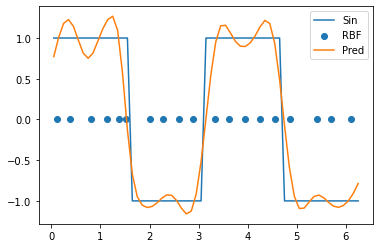

In [205]:

X_train, y_train_sin, y_train_square = get_train_data(noise)
X_test, y_test_sin, y_test_square = get_test_data(noise)

rbf_vq = RBFNet(k=best_k_square_cl, delta_epochs=200, cl_epochs=200)
y_pred_train_square = rbf_vq.fit_and_predict(X_train, y_train_square, rule="delta", cl="hard")

mae = rbf_vq.evaluate_residual_error(X_test, y_test_square)
y_pred_test_sin = rbf_vq.predict(X_test)

display(pd.DataFrame(rbf_vq.kernel_centers, rbf_vq.kernel_stds))

plot_rbf_with_data(rbf_vq, X_test, y_test_square)


In [148]:
noise = True

Kernels 1
Kernels 2
Loss: 27.2099
Residual Error (MAE): 0.5638

Kernels 3
Loss: 20.4888
Residual Error (MAE): 0.4600

Kernels 4
Loss: 10.7050
Residual Error (MAE): 0.3398

Kernels 5
Loss: 8.8039
Residual Error (MAE): 0.2690

Kernels 6
Loss: 6.3274
Residual Error (MAE): 0.2560

Kernels 7
Loss: 4.0577
Residual Error (MAE): 0.2090

Kernels 8
Loss: 3.0249
Residual Error (MAE): 0.1675

Kernels 9
Loss: 2.1129
Residual Error (MAE): 0.1707

Kernels 10
Loss: 2.6535
Residual Error (MAE): 0.1947

Kernels 11
Kernels 12
Loss: 1.2140
Residual Error (MAE): 0.1600

Kernels 13
Loss: 1.8798
Residual Error (MAE): 0.1624

Kernels 14
Loss: 1.2091
Residual Error (MAE): 0.1600

Kernels 15
Loss: 1.0063
Residual Error (MAE): 0.1456

Kernels 16
Kernels 17
Loss: 0.9461
Residual Error (MAE): 0.1425

Kernels 18
Loss: 1.4683
Residual Error (MAE): 0.1680

Kernels 19
Loss: 1.8129
Residual Error (MAE): 0.1702

Kernels 20
Loss: 0.9080
Residual Error (MAE): 0.1466

Kernels 21
Loss: 1.1237
Residual Error (MAE): 0.1592

K

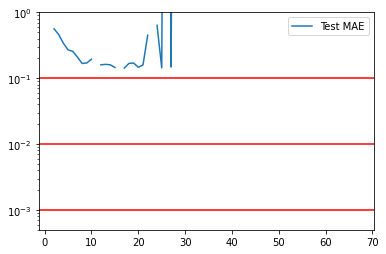

In [149]:

X_train, y_train_sin, y_train_square = get_train_data(noise)
X_test, y_test_sin, y_test_square = get_test_data(noise)

num_of_kernels = np.arange(1, 70, 1)
maes = []

for k in num_of_kernels:
    print(f"Kernels {k}")
    try:
        rbf_vq = RBFNet(k=k, delta_epochs=200, cl_epochs=200)

        y_pred_sin = rbf_vq.fit_and_predict(X_train, y_train_sin, rule="delta", cl="hard")

        mae = rbf_vq.evaluate_residual_error(X_test, y_test_sin)

        maes.append(mae)
        print("")
    except:
        maes.append(np.inf)

best_k_sin_cl = np.argmin(maes)
print("Best", best_k_sin_cl, maes[best_k_sin_cl])

plt.plot(num_of_kernels, maes, label="Test MAE")
plt.axhline(y=residual_error_thresholds[0], c="r")
plt.axhline(y=residual_error_thresholds[1], c="r")
plt.axhline(y=residual_error_thresholds[2], c="r")
plt.yscale('log')
plt.ylim(0.0005, 1)
#plt.yticks([0.1, 0.01, 0.001])
plt.legend()
plt.show()

Loss: 1.7443
Residual Error (MAE): 0.1462


,0
0.364460,0.914034
0.383179,1.803822
0.260100,4.677686
0.205916,6.112834
0.345372,4.999340
0.080983,0.638821
0.314233,2.716520
0.290597,3.614516
0.026760,3.995403
0.408910,0.236615


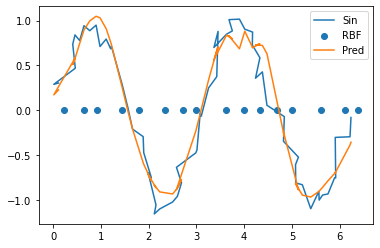

In [150]:

X_train, y_train_sin, y_train_square = get_train_data(noise)
X_test, y_test_sin, y_test_square = get_test_data(noise)

rbf_vq = RBFNet(k=best_k_sin_cl, delta_epochs=200, cl_epochs=200)
y_pred_train_sin = rbf_vq.fit_and_predict(X_train, y_train_sin, rule="delta", cl="hard")

sin_test_loss = rbf_vq.evaluate_residual_error(X_test, y_test_sin)
y_pred_test_sin = rbf_vq.predict(X_test)

display(pd.DataFrame(rbf_vq.kernel_centers, rbf_vq.kernel_stds))

plot_rbf_with_data(rbf_vq, X_test, y_test_sin)

Kernels 1
Kernels 2
Loss: 51.3557
Residual Error (MAE): 0.7966

Kernels 3
Loss: 48.0680
Residual Error (MAE): 0.7648

Kernels 4
Loss: 47.2410
Residual Error (MAE): 0.7425

Kernels 5
Loss: 13.3491
Residual Error (MAE): 0.3711

Kernels 6
Loss: 11.5529
Residual Error (MAE): 0.3725

Kernels 7
Loss: 13.8809
Residual Error (MAE): 0.4439

Kernels 8
Loss: 11.4720
Residual Error (MAE): 0.3346

Kernels 9
Loss: 10.5030
Residual Error (MAE): 0.3515

Kernels 10
Loss: 7.9423
Residual Error (MAE): 0.3140

Kernels 11
Loss: 6.8950
Residual Error (MAE): 0.2510

Kernels 12
Loss: 9.4326
Residual Error (MAE): 0.2889

Kernels 13
Loss: 6.3305
Residual Error (MAE): 0.2304

Kernels 14
Loss: 7.5993
Residual Error (MAE): 0.2689

Kernels 15
Loss: 6.7071
Residual Error (MAE): 0.2715

Kernels 16
Loss: 7.8355
Residual Error (MAE): 0.3110

Kernels 17
Kernels 18
Loss: 1055644669985868864303959759566929920.0000
Residual Error (MAE): 64476179477672952.0000

Kernels 19
Loss: 5.9097
Residual Error (MAE): 0.2478

Kernels 2

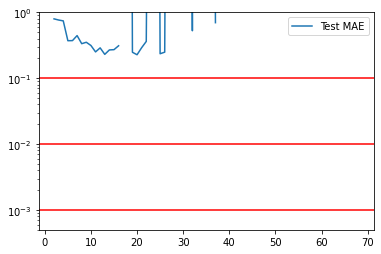

In [151]:

X_train, y_train_sin, y_train_square = get_train_data(noise)
X_test, y_test_sin, y_test_square = get_test_data(noise)

num_of_kernels = np.arange(1, 70, 1)
maes = []

for k in num_of_kernels:
    print(f"Kernels {k}")
    try:
        rbf_vq = RBFNet(k=k, delta_epochs=200, cl_epochs=200)

        y_pred_square = rbf_vq.fit_and_predict(X_train, y_train_square, rule="delta", cl="hard")

        mae = rbf_vq.evaluate_residual_error(X_test, y_test_square)

        maes.append(mae)
        print("")
    except:
        maes.append(np.inf)

best_k_square_cl = np.argmin(maes)
print("Best", best_k_square_cl, maes[best_k_square_cl])

plt.plot(num_of_kernels, maes, label="Test MAE")
plt.axhline(y=residual_error_thresholds[0], c="r")
plt.axhline(y=residual_error_thresholds[1], c="r")
plt.axhline(y=residual_error_thresholds[2], c="r")
plt.yscale('log')
plt.ylim(0.0005, 1)
#plt.yticks([0.1, 0.01, 0.001])
plt.legend()
plt.show()

Loss: 7.9535
Residual Error (MAE): 0.3287


,0
0.294333,5.736175
0.106283,4.294370
0.051474,-0.014244
0.259648,4.012534
0.185625,4.558283
0.306225,2.138624
0.238147,1.657345
0.093694,1.511789
0.240393,4.925430
0.216848,5.186637


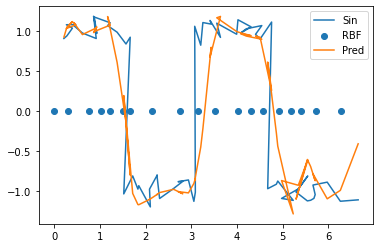

In [152]:

X_train, y_train_sin, y_train_square = get_train_data(noise)
X_test, y_test_sin, y_test_square = get_test_data(noise)

rbf_vq = RBFNet(k=best_k_square_cl, delta_epochs=200, cl_epochs=200)
y_pred_train_square = rbf_vq.fit_and_predict(X_train, y_train_square, rule="delta", cl="hard")

mae = rbf_vq.evaluate_residual_error(X_test, y_test_square)
y_pred_test_sin = rbf_vq.predict(X_test)

display(pd.DataFrame(rbf_vq.kernel_centers, rbf_vq.kernel_stds))

plot_rbf_with_data(rbf_vq, X_test, y_test_square)


Compare approaches
- VQ Prototype vectors become evenly space, similar to hand-picked vectors
    - VQ initialization is not as good as hand-picked
- Noise reduces performance
- Applying early stopping for both learning procedures might help
- Generalization
    - VQ is worse or better?


# 3.3.2 Soft winner

In [159]:
noise = False

Kernels 1
Kernels 2
Kernels 3
Kernels 4
Kernels 5
Kernels 6
Kernels 7
Kernels 8
Kernels 9
Kernels 10
Kernels 11
Kernels 12
Kernels 13
Kernels 14
Kernels 15
Kernels 16
Kernels 17
Kernels 18
Kernels 19
Kernels 20
Kernels 21
Kernels 22
Kernels 23
Kernels 24
Kernels 25
Kernels 26
Kernels 27
Kernels 28
Kernels 29
Kernels 30
Kernels 31
Kernels 32
Kernels 33
Kernels 34
Kernels 35
Kernels 36
Kernels 37
Kernels 38
Kernels 39
Kernels 40
Kernels 41
Kernels 42
Kernels 43
Kernels 44
Kernels 45
Kernels 46
Kernels 47
Kernels 48
Kernels 49
Kernels 50
Kernels 51
Kernels 52
Kernels 53
Kernels 54
Kernels 55
Kernels 56
Kernels 57
Kernels 58
Kernels 59
Kernels 60
Kernels 61
Kernels 62
Kernels 63
Kernels 64
Kernels 65
Kernels 66
Kernels 67
Kernels 68
Kernels 69
Best 0 inf


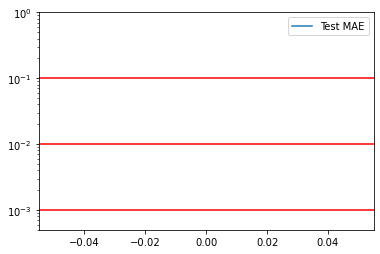

In [160]:

X_train, y_train_sin, y_train_square = get_train_data(noise)
X_test, y_test_sin, y_test_square = get_test_data(noise)

num_of_kernels = np.arange(1, 70, 1)
maes = []

for k in num_of_kernels:
    print(f"Kernels {k}")
    try:
        rbf_vq = RBFNet(k=k, delta_epochs=200, cl_epochs=200)

        y_pred_sin = rbf_vq.fit_and_predict(X_train, y_train_sin, rule="delta", cl="soft")

        mae = rbf_vq.evaluate_residual_error(X_test, y_test_sin)

        maes.append(mae)
        print("")
    except:
        maes.append(np.inf)

best_k_sin_cl = np.argmin(maes)
print("Best", best_k_sin_cl, maes[best_k_sin_cl])

plt.plot(num_of_kernels, maes, label="Test MAE")
plt.axhline(y=residual_error_thresholds[0], c="r")
plt.axhline(y=residual_error_thresholds[1], c="r")
plt.axhline(y=residual_error_thresholds[2], c="r")
plt.yscale('log')
plt.ylim(0.0005, 1)
#plt.yticks([0.1, 0.01, 0.001])
plt.legend()
plt.show()


[0.00000000e+000 1.00000000e+000 3.14508801e-289 0.00000000e+000
 7.75161983e-181 0.00000000e+000 0.00000000e+000 8.75281014e-213
 8.75281014e-213 9.03707078e-001 2.74310467e-004 7.75161983e-181
 9.80198673e-001 7.26149037e-001 0.00000000e+000]
[9.03707078e-001 0.00000000e+000 8.75281014e-213 3.12711698e-016
 0.00000000e+000 1.00000000e+000 6.75911459e-128 3.14508801e-289
 3.14508801e-289 0.00000000e+000 0.00000000e+000 0.00000000e+000
 0.00000000e+000 0.00000000e+000 6.75911459e-128]
[2.94535964e-162 2.88411461e-302 1.00000000e+000 5.53461007e-012
 9.03707078e-001 6.91712182e-234 9.03707078e-001 9.80198673e-001
 9.80198673e-001 1.15430908e-215 1.00335760e-057 9.03707078e-001
 2.44665236e-244 1.57060940e-183 9.03707078e-001]
[9.68777211e-001 0.00000000e+000 6.91712182e-234 2.68146897e-019
 0.00000000e+000 1.00000000e+000 7.32574175e-164 9.76111315e-290
 9.76111315e-290 0.00000000e+000 0.00000000e+000 0.00000000e+000
 0.00000000e+000 0.00000000e+000 7.32574175e-164]
[7.02319356e-261 1.1

,0
0.512348,5.843550
0.512348,0.535778
0.675584,3.536839
0.948683,4.740799
0.687386,3.536794
0.335410,5.844324
0.512348,3.536911
0.675584,3.536810
0.675584,3.536810
0.675584,0.535783


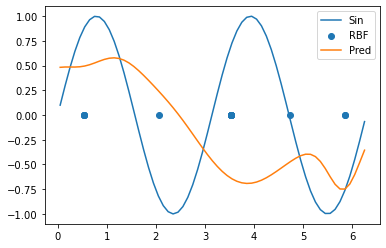

In [242]:

X_train, y_train_sin, y_train_square = get_train_data(noise)
X_test, y_test_sin, y_test_square = get_test_data(noise)

rbf_vq = RBFNet(k=15, delta_epochs=1, cl_epochs=2)
y_pred_train_sin = rbf_vq.fit_and_predict(X_train, y_train_sin, rule="delta", cl="soft")

sin_test_loss = rbf_vq.evaluate_residual_error(X_test, y_test_sin)
y_pred_test_sin = rbf_vq.predict(X_test)

display(pd.DataFrame(rbf_vq.kernel_centers, rbf_vq.kernel_stds))

plot_rbf_with_data(rbf_vq, X_test, y_test_sin)
